In [32]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error, r2_score
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense,Dropout
import tensorflow as tf
import random
from sklearn.model_selection import TimeSeriesSplit
import statsmodels.api as sm
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.layers import SimpleRNN

In [33]:
import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))


/kaggle/input/amirkabirdam/holiday.csv
/kaggle/input/amirkabirdam/dam12.csv
/kaggle/input/d/homaabedinzadeh/holidayname/holidayname.csv
/kaggle/input/d/homaabedinzadeh/futuredays/90days.csv
/kaggle/input/climate-indeices/ONI.xlsx
/kaggle/input/climate-indeices/ENSO.xlsx
/kaggle/input/climate-indeices/AMO.xlsx
/kaggle/input/climate-indeices/NAO.xlsx
/kaggle/input/climate-indeices/SOI.xlsx


In [34]:
oni = pd.read_excel('../input/climate-indeices/ONI.xlsx')
enso = pd.read_excel('../input/climate-indeices/ENSO.xlsx')
#amo = pd.read_excel('../input/climate-indeices/AMO.xlsx')
nao = pd.read_excel('../input/climate-indeices/NAO.xlsx')
soi = pd.read_excel('../input/climate-indeices/SOI.xlsx')


In [35]:
oni=pd.melt(oni, id_vars=['Year'], var_name='month', value_name='value').sort_values(by=['Year','month'])
enso=pd.melt(enso, id_vars=['Year'], var_name='month', value_name='value').sort_values(by=['Year','month'])
#amo=pd.melt(amo, id_vars=['Year'], var_name='month', value_name='value').sort_values(by=['Year','month'])
nao=pd.melt(nao, id_vars=['Year'], var_name='month', value_name='value').sort_values(by=['Year','month'])
soi=pd.melt(soi, id_vars=['Year'], var_name='month', value_name='value').sort_values(by=['Year','month'])

In [36]:
climate=soi.merge( nao ,how='left', on= ['Year', 'month'],suffixes=('_s', '_n') ).merge(oni,how='left', on= ['Year', 'month']).merge(enso,how='left', on= ['Year', 'month'],suffixes=('_a', '_e'))#.merge(amo,how='left', on= ['Year', 'month'])
climate.head(2)

,Year,month,value_s,value_n,value_a,value_e
0,1979,01,0.2,-1.38,0.0,0.26
1,1979,02,0.2,-0.67,0.1,-0.25


In [37]:
climate=climate.rename(columns={'value_s':'soi' ,'value_n':'nao' , 'value_a':'amo', 'value_e':'enso', 'value':'oni'})
climate.dropna(inplace=True)

In [38]:
climate.head(2)

,Year,month,soi,nao,amo,enso
0,1979,01,0.2,-1.38,0.0,0.26
1,1979,02,0.2,-0.67,0.1,-0.25


In [39]:

climate['soi30']=climate['soi'].shift(1)
climate['soi60']=climate['soi'].shift(2)
climate['soi90']=climate['soi'].shift(3)
climate['soi360']=climate['soi'].shift(12)

climate['nao30']=climate['nao'].shift(1)
climate['nao60']=climate['nao'].shift(2)
climate['nao90']=climate['nao'].shift(3)
climate['nao120']=climate['nao'].shift(4)
climate['nao150']=climate['nao'].shift(5)
climate['nao180']=climate['nao'].shift(6)
climate['nao270']=climate['nao'].shift(9)
climate['nao360']=climate['nao'].shift(12)

climate['amo30']=climate['amo'].shift(1)
climate['amo60']=climate['amo'].shift(2)
climate['amo90']=climate['amo'].shift(3)
climate['amo360']=climate['amo'].shift(12)

climate['enso30']=climate['enso'].shift(1)
climate['enso60']=climate['enso'].shift(2)
climate['enso90']=climate['enso'].shift(3)
climate['enso360']=climate['enso'].shift(12)

In [40]:
df = pd.read_csv('../input/amirkabirdam/dam12.csv')
df['Total_in'].head(2)

0    2.80800
1    0.28512
Name: Total_in, dtype: float64

In [41]:
df['humidity']=df[['NamNesbi6_5', 'NamNesbi12_5','NamNesbi18_5']].mean(axis=1)
df['daraje']= df[['MinDarajehararat_in','MaxDarajehararat_in']].mean(axis=1)

In [42]:
df['DateRow'] = pd.to_datetime(df['DateRow'])
df = df.sort_values(by= 'DateRow')

In [43]:
cal=['Year','month','day_of_week','day_of_year']

df['Year'] = df['DateRow'].dt.year
df['month'] = df['DateRow'].dt.month
df['day_of_week'] = df['DateRow'].dt.dayofweek
df['day_of_year'] = df['DateRow'].dt.dayofyear
df.drop(columns=['DateRow'], inplace=True)


#df =pd.concat ([df[features], df[cal],df [target]], axis=1)


In [44]:
target = 'Total_in'
features = ['Barandegi_in','TotalAbBarfVBaran_in','DebiSeilabm3c','daraje','VazeHava_in','SoratBad_in' ,'humidity']

df1= df[features + [target]]

In [45]:
climate['month']=climate['month'].astype('int32')

In [46]:
df= climate.merge(df , how= 'inner' , on = ['Year', 'month'],suffixes=('_x', '_y'))

In [47]:
cli=['soi', 'nao', 'amo', 'enso', 'soi30', 'soi60', 'soi90',
       'soi360', 'nao30', 'nao60', 'nao90', 'nao120', 'nao150', 'nao180',
       'nao270', 'nao360', 'amo30', 'amo60', 'amo90', 'amo360', 'enso30',
       'enso60', 'enso90', 'enso360','Year', 'month', 'day_of_week', 'day_of_year']

In [48]:
shift=[1,2,7,30,90,120,150,180,270,365]
temp=pd.DataFrame()
def create_shifted_dataframe(df, column_name, shift_period):
    shifted_column = df[column_name].shift(periods=shift_period)
    r_column_m= df[column_name].shift(periods=1).rolling(window=shift_period).mean()
    shift_df = pd.DataFrame({f"{column_name}_{shift_period}": shifted_column})
    roll_df = pd.DataFrame({f"{column_name}_{shift_period}": r_column_m})
    return (shift_df,roll_df)

for i in range (len (shift)):
    for j in range(len (df[features + [target]].columns)):
        temp[df1.columns[j]+'_rm_'+str(shift[i])],temp[df1.columns[j]+str(shift[i])] = (create_shifted_dataframe(df1,df1.columns[j], shift[i]))

final=pd.concat([df1,temp,df[cli]] , axis=1)    

/tmp/ipykernel_34/383341424.py:12: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  temp[df1.columns[j]+'_rm_'+str(shift[i])],temp[df1.columns[j]+str(shift[i])] = (create_shifted_dataframe(df1,df1.columns[j], shift[i]))
/tmp/ipykernel_34/383341424.py:12: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  temp[df1.columns[j]+'_rm_'+str(shift[i])],temp[df1.columns[j]+str(shift[i])] = (create_shifted_dataframe(df1,df1.columns[j], shift[i]))
/tmp/ipykernel_34/383341424.py:12: PerformanceWarning: DataFrame is highly fragmented.  This is usua

In [49]:
final=final[final['Year']>=2015]

In [50]:
final.dropna(axis=0, inplace=True)

In [51]:
final.shape

(2899, 196)

In [52]:
m=pd.DataFrame(final.corr()['Total_in'])
final=final [m[m['Total_in']>0.1].index]

In [53]:
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(final.values.reshape(-1, 1))
#scaler.fit_transform(m.values.reshape(-1, 1))

In [24]:
def create_dataset(dataset, time_step=10):
    X, y = [], []
    for i in range(len(dataset)-time_step-forecast_horizon):
        X.append(dataset[i:(i+time_step), :])
        y.append(dataset[i+time_step+forecast_horizon, -1])
    return np.array(X), np.array(y)

time_step = 180
forecast_horizon = 30
#X, y = create_dataset_multistep(scaled_data, time_step, forecast_horizon)

In [25]:
X_rnn, y_rnn = create_dataset(scaled_data, time_step)

In [26]:

X_rnn = X_rnn.reshape(X_rnn.shape[0], X_rnn.shape[1], X_rnn.shape[2])


In [29]:
tscv = TimeSeriesSplit(n_splits = 7)
train_rmse = []
test_rmse = []
train_r2 = []
test_r2 = []
i=0
for train_index, test_index in tscv.split(X_rnn):
    i+=1
    X_train, X_test = X_rnn[train_index], X_rnn[test_index]
    Y_train, Y_test = y_rnn[train_index], y_rnn[test_index]
    if i>=3:
        model = Sequential()
        model.add(SimpleRNN(128, activation='relu', input_shape=(X_rnn.shape[1], X_rnn.shape[2])))
        model.add(Dropout(0.2))
        model.add(Dense(64))
        model.add(Dropout(0.2))
        model.add(Dense(64))
        model.add(Dense(1))  # خروجی یک روز بعد (پیش‌بینی)

        # کامپایل مدل
        model.compile(optimizer='adam', loss='mean_squared_error')
        early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
        # آموزش مدل
        model.fit(X_rnn, y_rnn, epochs=10, batch_size=64,callbacks=[early_stopping],validation_data=(X_test, Y_test))
        train_predict = model.predict(X_train)
        test_predict = model.predict(X_test)
        
        train_rmse .append (np.sqrt(mean_squared_error(Y_train, train_predict)))
        test_rmse.append ( np.sqrt(mean_squared_error(Y_test, test_predict)))
        train_r2 .append ( r2_score(Y_train, train_predict))
        test_r2 .append ( r2_score(Y_test, test_predict))
    
print(f"Train RMSE: {np.mean(train_rmse)}, Test RMSE: {np.mean(test_rmse)}")
print(f"Train R2: {np.mean(train_r2)}, Test R2: {np.mean(test_r2)}")
    

Epoch 1/10
639/639 ━━━━━━━━━━━━━━━━━━━━ 38s 57ms/step - loss: 0.0012 - val_loss: 5.1602e-04
Epoch 2/10
639/639 ━━━━━━━━━━━━━━━━━━━━ 36s 57ms/step - loss: 4.8046e-04 - val_loss: 4.5742e-04
Epoch 3/10
639/639 ━━━━━━━━━━━━━━━━━━━━ 35s 56ms/step - loss: 4.6362e-04 - val_loss: 5.1180e-04
Epoch 4/10
639/639 ━━━━━━━━━━━━━━━━━━━━ 36s 56ms/step - loss: 4.6038e-04 - val_loss: 4.6705e-04
Epoch 5/10
639/639 ━━━━━━━━━━━━━━━━━━━━ 35s 55ms/step - loss: 4.3897e-04 - val_loss: 5.6431e-04
Epoch 6/10
639/639 ━━━━━━━━━━━━━━━━━━━━ 35s 54ms/step - loss: 4.4257e-04 - val_loss: 5.3084e-04
Epoch 7/10
639/639 ━━━━━━━━━━━━━━━━━━━━ 35s 54ms/step - loss: 4.4795e-04 - val_loss: 5.6919e-04
480/480 ━━━━━━━━━━━━━━━━━━━━ 7s 15ms/step
160/160 ━━━━━━━━━━━━━━━━━━━━ 2s 15ms/step
Epoch 1/10


/opt/conda/lib/python3.10/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


639/639 ━━━━━━━━━━━━━━━━━━━━ 38s 55ms/step - loss: 0.0011 - val_loss: 4.4762e-04
Epoch 2/10
639/639 ━━━━━━━━━━━━━━━━━━━━ 35s 55ms/step - loss: 4.8091e-04 - val_loss: 4.1542e-04
Epoch 3/10
639/639 ━━━━━━━━━━━━━━━━━━━━ 35s 55ms/step - loss: 4.6516e-04 - val_loss: 4.3100e-04
Epoch 4/10
639/639 ━━━━━━━━━━━━━━━━━━━━ 35s 55ms/step - loss: 4.6552e-04 - val_loss: 4.6050e-04
Epoch 5/10
639/639 ━━━━━━━━━━━━━━━━━━━━ 35s 55ms/step - loss: 4.5824e-04 - val_loss: 4.5336e-04
Epoch 6/10
639/639 ━━━━━━━━━━━━━━━━━━━━ 35s 55ms/step - loss: 4.5309e-04 - val_loss: 4.3328e-04
Epoch 7/10
639/639 ━━━━━━━━━━━━━━━━━━━━ 35s 55ms/step - loss: 4.5683e-04 - val_loss: 5.4083e-04
640/640 ━━━━━━━━━━━━━━━━━━━━ 10s 15ms/step
160/160 ━━━━━━━━━━━━━━━━━━━━ 2s 15ms/step
Epoch 1/10


/opt/conda/lib/python3.10/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


639/639 ━━━━━━━━━━━━━━━━━━━━ 37s 55ms/step - loss: 8.3363e-04 - val_loss: 8.3723e-04
Epoch 2/10
639/639 ━━━━━━━━━━━━━━━━━━━━ 35s 55ms/step - loss: 4.6769e-04 - val_loss: 7.6002e-04
Epoch 3/10
639/639 ━━━━━━━━━━━━━━━━━━━━ 35s 55ms/step - loss: 4.6433e-04 - val_loss: 7.5654e-04
Epoch 4/10
639/639 ━━━━━━━━━━━━━━━━━━━━ 35s 55ms/step - loss: 4.5855e-04 - val_loss: 8.0507e-04
Epoch 5/10
639/639 ━━━━━━━━━━━━━━━━━━━━ 35s 55ms/step - loss: 4.4177e-04 - val_loss: 8.3806e-04
Epoch 6/10
639/639 ━━━━━━━━━━━━━━━━━━━━ 35s 54ms/step - loss: 4.4303e-04 - val_loss: 8.1993e-04
Epoch 7/10
639/639 ━━━━━━━━━━━━━━━━━━━━ 35s 54ms/step - loss: 4.5008e-04 - val_loss: 8.3429e-04
Epoch 8/10
639/639 ━━━━━━━━━━━━━━━━━━━━ 35s 54ms/step - loss: 4.4871e-04 - val_loss: 7.6402e-04
799/799 ━━━━━━━━━━━━━━━━━━━━ 12s 15ms/step
160/160 ━━━━━━━━━━━━━━━━━━━━ 2s 15ms/step
Epoch 1/10


/opt/conda/lib/python3.10/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


639/639 ━━━━━━━━━━━━━━━━━━━━ 37s 55ms/step - loss: 8.1793e-04 - val_loss: 7.1941e-04
Epoch 2/10
639/639 ━━━━━━━━━━━━━━━━━━━━ 35s 55ms/step - loss: 4.7258e-04 - val_loss: 6.8737e-04
Epoch 3/10
639/639 ━━━━━━━━━━━━━━━━━━━━ 35s 55ms/step - loss: 4.6522e-04 - val_loss: 7.1607e-04
Epoch 4/10
639/639 ━━━━━━━━━━━━━━━━━━━━ 35s 55ms/step - loss: 4.5235e-04 - val_loss: 7.0675e-04
Epoch 5/10
639/639 ━━━━━━━━━━━━━━━━━━━━ 35s 54ms/step - loss: 4.4492e-04 - val_loss: 6.8016e-04
Epoch 6/10
639/639 ━━━━━━━━━━━━━━━━━━━━ 35s 55ms/step - loss: 4.4831e-04 - val_loss: 7.3365e-04
Epoch 7/10
639/639 ━━━━━━━━━━━━━━━━━━━━ 35s 55ms/step - loss: 4.4843e-04 - val_loss: 8.4962e-04
Epoch 8/10
639/639 ━━━━━━━━━━━━━━━━━━━━ 35s 55ms/step - loss: 4.4457e-04 - val_loss: 8.2982e-04
Epoch 9/10
639/639 ━━━━━━━━━━━━━━━━━━━━ 35s 54ms/step - loss: 4.3407e-04 - val_loss: 6.9894e-04
Epoch 10/10
639/639 ━━━━━━━━━━━━━━━━━━━━ 35s 54ms/step - loss: 4.3230e-04 - val_loss: 6.9775e-04
959/959 ━━━━━━━━━━━━━━━━━━━━ 14s 15ms/step
160/160

/opt/conda/lib/python3.10/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


639/639 ━━━━━━━━━━━━━━━━━━━━ 37s 55ms/step - loss: 8.6667e-04 - val_loss: 2.6175e-04
Epoch 2/10
639/639 ━━━━━━━━━━━━━━━━━━━━ 35s 55ms/step - loss: 4.6781e-04 - val_loss: 2.5334e-04
Epoch 3/10
639/639 ━━━━━━━━━━━━━━━━━━━━ 35s 55ms/step - loss: 4.4970e-04 - val_loss: 2.8059e-04
Epoch 4/10
639/639 ━━━━━━━━━━━━━━━━━━━━ 35s 54ms/step - loss: 4.5036e-04 - val_loss: 2.9747e-04
Epoch 5/10
639/639 ━━━━━━━━━━━━━━━━━━━━ 35s 54ms/step - loss: 4.5847e-04 - val_loss: 2.4915e-04
Epoch 6/10
639/639 ━━━━━━━━━━━━━━━━━━━━ 35s 55ms/step - loss: 4.3999e-04 - val_loss: 3.2415e-04
Epoch 7/10
639/639 ━━━━━━━━━━━━━━━━━━━━ 35s 55ms/step - loss: 4.4749e-04 - val_loss: 3.2816e-04
Epoch 8/10
639/639 ━━━━━━━━━━━━━━━━━━━━ 35s 54ms/step - loss: 4.3246e-04 - val_loss: 2.8053e-04
Epoch 9/10
639/639 ━━━━━━━━━━━━━━━━━━━━ 35s 55ms/step - loss: 4.3043e-04 - val_loss: 2.6739e-04
Epoch 10/10
639/639 ━━━━━━━━━━━━━━━━━━━━ 35s 55ms/step - loss: 4.2048e-04 - val_loss: 2.8804e-04
1119/1119 ━━━━━━━━━━━━━━━━━━━━ 17s 15ms/step
160/1

In [27]:
final.shape

(2899, 70)

In [54]:
def create_dataset(dataset, time_step=180 , forecast_horizon=1):
    X, y = [], []
    for i in range(len(dataset)-time_step-forecast_horizon):
        X.append(dataset[i:(i+time_step),: ])
        y.append(dataset[i+time_step+forecast_horizon, -1])
    return np.array(X), np.array(y)

time_step = 180
forecast_horizon =1
X, y = create_dataset(scaled_data, time_step, forecast_horizon)
print(X.shape)  
print(y.shape)

(202749, 180, 1)
(202749,)


In [ ]:
train_rmse = []
test_rmse = []
train_r2 = []
test_r2 = []

tscv = TimeSeriesSplit(n_splits=7)
i = 0
for train_index, test_index in tscv.split(X):
    i += 1
    X_train, X_test = X[train_index], X[test_index]
    Y_train, Y_test = y[train_index], y[test_index]
    
    if i >= 3:
        # تعریف مدل SimpleRNN
        model = Sequential()
        model.add(SimpleRNN(128, activation='relu', input_shape=(X_train.shape[1], X_train.shape[2])))
        model.add(Dropout(0.2))
        model.add(Dense(64))
        model.add(Dropout(0.2))
        #model.add(Dense(64))
        model.add(Dense(1))  # خروجی یک روز بعد (پیش‌بینی)

        # کامپایل مدل
        model.compile(optimizer='adam', loss='mean_squared_error')
        
        # Early Stopping
        early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
        
        # آموزش مدل فقط با داده‌های آموزشی
        model.fit(X_train, Y_train, epochs=10, batch_size=64, 
                  validation_data=(X_test, Y_test), callbacks=[early_stopping])
        
        # پیش‌بینی برای داده‌های تست
        test_predict = model.predict(X_test)
        train_predict = model.predict(X_train)
        
        # ارزیابی مدل
        test_rmse.append(np.sqrt(mean_squared_error(Y_test, test_predict)))
        train_rmse.append(np.sqrt(mean_squared_error(Y_train, train_predict)))
        test_r2.append(r2_score(Y_test, test_predict))
        train_r2.append(r2_score(Y_train, train_predict))
        
        # پیش‌بینی 90 روز آینده
        predicted_90_days = []
        last_90_days = X[-1]
        for _ in range(90):
            pred = model.predict(last_90_days.reshape(1, X.shape[1], X.shape[2]))
            predicted_90_days.append(pred[0][0])
            last_90_days = np.append(last_90_days[1:], pred, axis=0)
        
        # مقیاس‌دهی معکوس برای 90 روز پیش‌بینی‌شده
        predicted_90_days_original = scaler.inverse_transform(np.array(predicted_90_days).reshape(-1, 1))

# چاپ نتایج نهایی ارزیابی مدل
print(f"Train RMSE: {np.mean(train_rmse)}")
print(f"Test RMSE: {np.mean(test_rmse)}")
print(f"Train R2: {np.mean(train_r2)}")
print(f"Test R2: {np.mean(test_r2)}")

# چاپ پیش‌بینی 90 روز آینده
#print(predicted_90_days_original)

/opt/conda/lib/python3.10/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/10
1189/1189 ━━━━━━━━━━━━━━━━━━━━ 77s 64ms/step - loss: 0.0034 - val_loss: 0.0033
Epoch 2/10
1189/1189 ━━━━━━━━━━━━━━━━━━━━ 75s 63ms/step - loss: 0.0016 - val_loss: 0.0017
Epoch 3/10
1189/1189 ━━━━━━━━━━━━━━━━━━━━ 75s 63ms/step - loss: 0.0021 - val_loss: 0.0049
Epoch 4/10
1189/1189 ━━━━━━━━━━━━━━━━━━━━ 76s 64ms/step - loss: 0.0047 - val_loss: 0.0049
Epoch 5/10
1189/1189 ━━━━━━━━━━━━━━━━━━━━ 77s 65ms/step - loss: 0.0047 - val_loss: 0.0049
Epoch 6/10
1189/1189 ━━━━━━━━━━━━━━━━━━━━ 77s 65ms/step - loss: 0.0047 - val_loss: 0.0041
Epoch 7/10
1189/1189 ━━━━━━━━━━━━━━━━━━━━ 75s 63ms/step - loss: 0.0038 - val_loss: 0.0027
792/792 ━━━━━━━━━━━━━━━━━━━━ 13s 17ms/step
2377/2377 ━━━━━━━━━━━━━━━━━━━━ 39s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━

/opt/conda/lib/python3.10/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/10
1585/1585 ━━━━━━━━━━━━━━━━━━━━ 98s 61ms/step - loss: 0.0029 - val_loss: 0.0011
Epoch 2/10
1585/1585 ━━━━━━━━━━━━━━━━━━━━ 96s 60ms/step - loss: 0.0014 - val_loss: 0.0014
Epoch 3/10
1585/1585 ━━━━━━━━━━━━━━━━━━━━ 97s 61ms/step - loss: 0.0025 - val_loss: 0.0017
Epoch 4/10
1585/1585 ━━━━━━━━━━━━━━━━━━━━ 98s 62ms/step - loss: 0.0017 - val_loss: 0.0013
Epoch 5/10
1585/1585 ━━━━━━━━━━━━━━━━━━━━ 97s 61ms/step - loss: 0.0019 - val_loss: 0.0018
Epoch 6/10
1585/1585 ━━━━━━━━━━━━━━━━━━━━ 96s 61ms/step - loss: 0.0017 - val_loss: 0.0015
792/792 ━━━━━━━━━━━━━━━━━━━━ 13s 16ms/step
3169/3169 ━━━━━━━━━━━━━━━━━━━━ 51s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27

/opt/conda/lib/python3.10/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/10
1980/1980 ━━━━━━━━━━━━━━━━━━━━ 113s 56ms/step - loss: 0.0027 - val_loss: 0.0013
Epoch 2/10
1980/1980 ━━━━━━━━━━━━━━━━━━━━ 110s 55ms/step - loss: 0.0014 - val_loss: 0.0011
Epoch 3/10
1980/1980 ━━━━━━━━━━━━━━━━━━━━ 110s 56ms/step - loss: 0.0013 - val_loss: 0.0011
Epoch 4/10
1980/1980 ━━━━━━━━━━━━━━━━━━━━ 111s 56ms/step - loss: 333013088.0000 - val_loss: 0.0030
Epoch 5/10
1980/1980 ━━━━━━━━━━━━━━━━━━━━ 111s 56ms/step - loss: 0.0039 - val_loss: 0.0023
Epoch 6/10
1980/1980 ━━━━━━━━━━━━━━━━━━━━ 110s 56ms/step - loss: 0.0031 - val_loss: 0.0019
Epoch 7/10
1980/1980 ━━━━━━━━━━━━━━━━━━━━ 109s 55ms/step - loss: 0.0026 - val_loss: 0.0016
Epoch 8/10
1980/1980 ━━━━━━━━━━━━━━━━━━━━ 112s 56ms/step - loss: 0.0022 - val_loss: 0.0015
792/792 ━━━━━━━━━━━━━━━━━━━━ 13s 16ms/step
3960/3960 ━━━━━━━━━━━━━━━━━━━━ 65s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━

/opt/conda/lib/python3.10/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/10
2376/2376 ━━━━━━━━━━━━━━━━━━━━ 147s 61ms/step - loss: 0.0026 - val_loss: 0.0013
Epoch 2/10
2376/2376 ━━━━━━━━━━━━━━━━━━━━ 144s 60ms/step - loss: 0.0019 - val_loss: 0.0020
Epoch 3/10
2376/2376 ━━━━━━━━━━━━━━━━━━━━ 141s 59ms/step - loss: 0.0034 - val_loss: 0.0038
Epoch 4/10
2376/2376 ━━━━━━━━━━━━━━━━━━━━ 141s 59ms/step - loss: 0.0046 - val_loss: 0.0033
Epoch 5/10
2376/2376 ━━━━━━━━━━━━━━━━━━━━ 142s 60ms/step - loss: 0.0032 - val_loss: 0.0024
Epoch 6/10
2376/2376 ━━━━━━━━━━━━━━━━━━━━ 142s 60ms/step - loss: 0.0025 - val_loss: 0.0014
792/792 ━━━━━━━━━━━━━━━━━━━━ 13s 17ms/step
4277/4752 ━━━━━━━━━━━━━━━━━━━━ 7s 16ms/step

In [27]:
predicted_90_days_original=pd.DataFrame (predicted_90_days_original)
predicted_90_days_original.head(2)

,0
0,0.151237
1,-0.066428


In [28]:
features_days = pd.read_csv('../input/d/homaabedinzadeh/futuredays/90days.csv')
features_days.head(2)

,Total_in
0,0.23158
1,0.22716


In [29]:
features_days.shape

(90, 1)

In [47]:
k=pd.concat ([features_days, predicted_90_days_original], names=['main','pred'], axis=1)

In [49]:
names=['main','pred']

In [50]:
k.columns= names

In [53]:
k.head()

,main,pred
0,0.23158,0.151237
1,0.22716,-0.066428
2,0.22194,0.157983
3,0.22305,0.041600
4,0.22562,0.431176


In [30]:
print (r2_score(features_days, predicted_90_days_original))

-0.5649794611949763


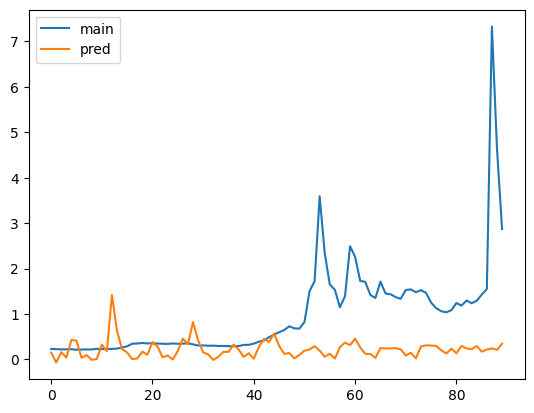

In [52]:
k.plot(y=["main", "pred"])
plt.show()